In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#!pip install catboost
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [6]:
cd /content/drive/My Drive/FORCE-Lithology-Prediction/

/content/drive/My Drive/FORCE-Lithology-Prediction


In [7]:
import wavelet_transform

In [8]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data
 
def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata
 
def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata
 
def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, -999, traindata[_])
        
    return traindata
 
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data
 
 
def mean_target(data, cols):
    kf = StratifiedKFold(10, shuffle=False)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data, data.FORCE_2020_LITHOFACIES_LITHOLOGY):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a
 
def make_submission(prediction, filename):
 
  path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'
 
  test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
  #test_prediction = model.predict(testdata)
 
  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')
 
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [9]:
A = np.load('/content/drive/My Drive/FORCE-Lithology-Prediction/penalty_matrix.npy')
 
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]
 
def evaluate(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(24,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [10]:
#importing files
train = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/train1.csv')
test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
valid1 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid4.csv')
valid2 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid5.csv')
valid3 = pd.concat((valid1, valid2)).reset_index(drop=True)

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
nvalid1 = valid1.shape[0]
nvalid2 = valid2.shape[0]
nvalid3 = valid3.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test, valid1, valid2, valid3)).reset_index(drop=True)

In [12]:
df.shape

(1512843, 29)

In [13]:
df = wavelet_transform.wavelet_transform(df)
df.shape

(1512843, 35)

In [15]:
df.head(1)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,coef_0,coef_2,coef_4,phase_0,phase_2,phase_4
0,15/9-15,485.256,436817.90625,6462991.5,-460.255005,NORDLAND GP.,NaN,NaN,1.567587,1.567587,1.735962,NaN,78.275825,NaN,NaN,NaN,161.94751,45.884998,26.000002,46.064972,NaN,NaN,NaN,0.133007,NaN,NaN,-999.900024,65000.0,3.0,78.285524,79.702544,71.990193,-1.587807,-1.531941,-1.528543


In [16]:
train_well = train.WELL.values
train_depth = train.DEPTH_MD.values
 
valid1_well = valid1.WELL.values
valid1_depth = valid1.DEPTH_MD.values
 
valid2_well = valid2.WELL.values
valid2_depth = valid2.DEPTH_MD.values
 
valid3_well = valid3.WELL.values
valid3_depth = valid3.DEPTH_MD.values

In [17]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid3_lithology = valid3['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid3_lithology = valid3_lithology.map(lithology_numbers)

In [18]:
nr.seed(2020)

In [19]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA']
df = drop_columns(df, *cols)
print(df.shape)

(1512843, 35)
(1512843, 30)


In [20]:
nr.seed(2020)

In [21]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes

In [22]:
nr.seed(2020)

In [23]:
df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
df.shape
 
df = df.fillna(-999)
df = process(df)
data = df.copy()
 
train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation1_target = valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation2_target = valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
 
test2 = data[ntrain:(ntest+ntrain)].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)
 
validation1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
validation1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation1 = validation1.reset_index(drop=True)
 
validation2 = data[(ntrain+ntest+nvalid1): (ntrain+ntest+nvalid1+nvalid2)].copy()
validation2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation2 = validation2.reset_index(drop=True)
 
 
validation3 = data[(ntrain+ntest+nvalid1+nvalid2):].copy()
validation3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation3 = validation3.reset_index(drop=True)
 
print(train2.shape, test2.shape, validation1.shape, valid1.shape, validation2.shape, validation3.shape, valid2.shape)

(964965, 29) (136786, 29) (114079, 29) (114079, 29) (91467, 29) (205546, 29) (91467, 29)


In [24]:
nr.seed(2020)

In [25]:
traindata = train2
testdata = test2

In [26]:
testdata.head(1)

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,coef_0,coef_2,coef_4,phase_0,phase_2,phase_4,GROUP_encoded,FORMATION_encoded,WELL_encoded
0,480.628001,423244.5,6461862.5,-455.62442,19.2031,-999.0,1.613886,1.513937,2.171173,72.078377,0.551575,55.815659,174.347092,35.525719,-999.0,96.46199,-999.0,-0.538873,0.130611,-999.0,1.426177,3.016086,10.24746,2.83802,-1.048308,-0.910008,6,-1,1


In [27]:
traindata, padded_rows = augment_features(traindata.values, train_well, train_depth)
validation1, padded_rows1= augment_features(validation1.values, valid1_well, valid1_depth)
validation2, padded_rows2 = augment_features(validation2.values, valid2_well, valid2_depth)
validation3, padded_rows3 = augment_features(validation3.values, valid3_well, valid3_depth)

In [28]:
traindata.shape

(964965, 116)

In [29]:
nr.seed(2020)

In [30]:
class Model():
    
    def __init__(self, train, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        #self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 10

      nr.seed(2020)
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      #pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
      nr.seed(2020)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        nr.seed(2020)
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(pd.DataFrame(self.validation1))
        prediction = model.predict(pd.DataFrame(self.validation2))
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.test)
        val1 += model.predict_proba(pd.DataFrame(self.validation1))
        val2 += model.predict_proba(pd.DataFrame(self.validation2))
        val3 += model.predict_proba(pd.DataFrame(self.validation3))
      
      #pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val1, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val2, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val3, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.17308
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.319221
Default score: -0.6134433155970862
Accuracy is: 0.7690372461189176
F1 is: 0.8082213250309733
None
Default score: -0.5532910776564225
Accuracy is: 0.7927011927799097
F1 is: 0.8204294217059683
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.17289
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.321967
Default score: -0.6118851848280578
Accuracy is: 0.7699138316429842
F1 is: 0.8076267074909949
None
Default score: -0.5545674942875572
Accuracy is: 0.793925678113418
F1 is: 0.8204685564711113
None
-----------------------FOLD 2---------------------
[0]	validation_0-mlogloss:2.17222
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.316247
Default score: -0.612335530641047
Accuracy is: 0.7693089876313782
F1 is: 0.807954632423

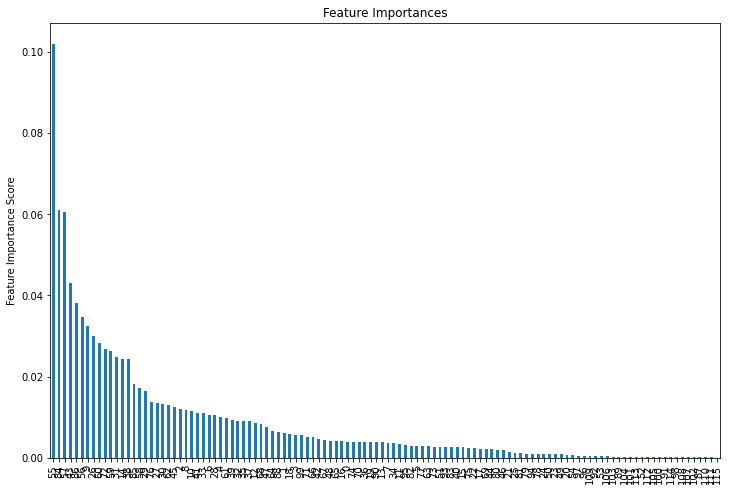

In [31]:
func1_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val1, open_test1, open_test11, model1 = func1_()   #no reglambda, 0.01 lr, 6max-depth (dts, rxo, sgr, ropa)

In [ ]:
print(show_evaluation(val1,valid1_lithology))
print(show_evaluation(open_test1, valid2_lithology))
print(show_evaluation(open_test11, valid3_lithology))

Default score: -0.6287890409277781
Accuracy is: 0.7649523575767669
F1 is: 0.8072991891979571
None
Default score: -0.5854133184645829
Accuracy is: 0.785398012397914
F1 is: 0.8225863227488472
None
Default score: -0.6094870491276891
Accuracy is: 0.7740505774863048
F1 is: 0.8132635081176378
None
